In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [4]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [5]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    concat_df = concat_df.reset_index(drop=True)
    
    return concat_df

In [6]:
house_df = data_prep('오피스텔', '매매')
print(house_df.shape)
house_df.head()

16it [00:00, 34.07it/s]


(178693, 11)


,지번주소,도로명,단지명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,6400,8,1997.0,9.0,2006-01-10,197.287300,24.0
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7100,7,1997.0,9.0,2006-01-10,218.865598,24.0
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7300,11,1997.0,9.0,2006-01-11,225.030826,24.0
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,7500,10,1997.0,9.0,2006-01-18,235.036039,24.0
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7400,15,1997.0,9.0,2006-01-19,228.113440,24.0


In [7]:
def land_shape2(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        if '사다리' in x:
            return '사다리형'
        elif '장방' in x:
            return '장방형'
        elif '정방' in x:
            return '정방형'
        elif '부정' in x:
            return '부정형'
        elif '않음' in x:
            return '지정되지않음'
        elif '자루' in x:
            return '자루형'
        elif '삼각' in x:
            return '삼각형'
        else:
            return '기타'

In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
land_specs_df['지형형상2'] = land_specs_df['지형형상'].apply(land_shape2)
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 12)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가,지형형상2
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0,부정형
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0,부정형
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0,부정형
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0,부정형
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0,부정형


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 10)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,부정형
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지,부정형
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지,부정형
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지,부정형
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지,부정형


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '금천구'
target_dong = '가산동'
#target_purpose = '준공업'

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(years=3)))
    &(house_merge_df['건물연식'] <= 3)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(218, 22)


,지번주소,도로명,단지명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동
168303,서울특별시 금천구 가산동 535-55,가산디지털2로 169-37,가산유미어스오피스텔,17.16,7864,2,2018.0,0.0,2018-07-19,458.275058,3.0,대,2754.0,준공업지역,지정되지않음,공업기타,평지,부정형,중로각지,부정형,금천구,가산동
168304,서울특별시 금천구 가산동 535-55,가산디지털2로 169-37,가산유미어스오피스텔,17.16,15000,13,2018.0,1.0,2019-04-22,874.125874,3.0,대,2754.0,준공업지역,지정되지않음,공업기타,평지,부정형,중로각지,부정형,금천구,가산동
168305,서울특별시 금천구 가산동 535-55,가산디지털2로 169-37,가산유미어스오피스텔,17.16,13000,4,2018.0,1.0,2019-12-25,757.575758,3.0,대,2754.0,준공업지역,지정되지않음,공업기타,평지,부정형,중로각지,부정형,금천구,가산동
168306,서울특별시 금천구 가산동 535-55,가산디지털2로 169-37,가산유미어스오피스텔,17.16,13500,13,2018.0,2.0,2020-04-06,786.713287,3.0,대,2754.0,준공업지역,지정되지않음,공업기타,평지,부정형,중로각지,부정형,금천구,가산동
168307,서울특별시 금천구 가산동 535-55,가산디지털2로 169-37,가산유미어스오피스텔,17.16,14000,8,2018.0,2.0,2020-06-03,815.850816,3.0,대,2754.0,준공업지역,지정되지않음,공업기타,평지,부정형,중로각지,부정형,금천구,가산동


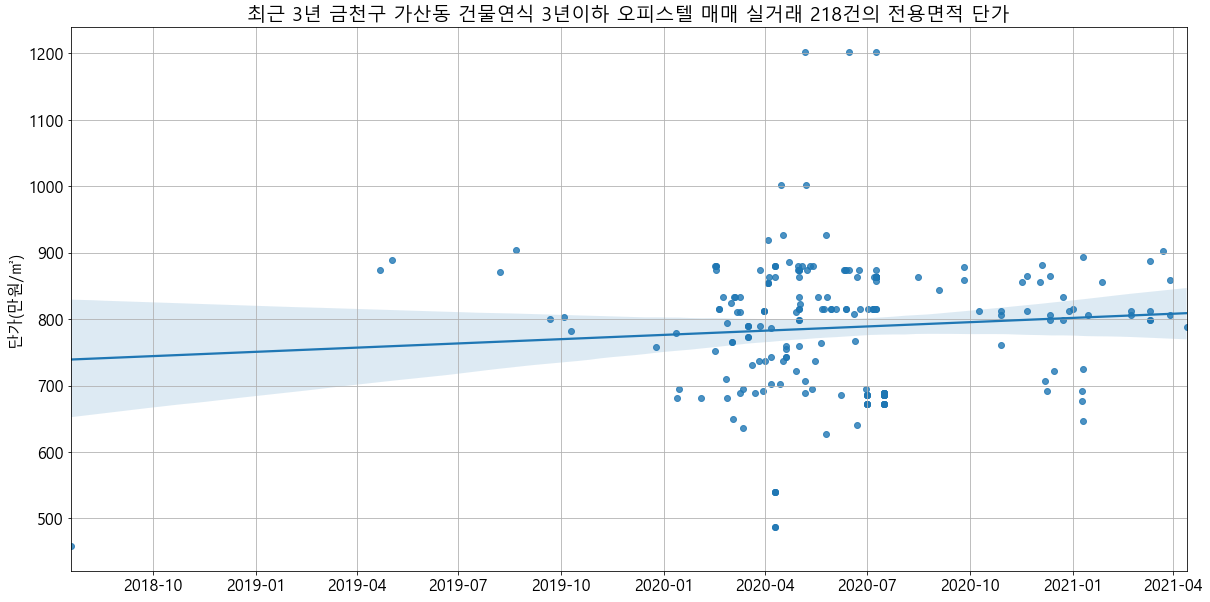

In [15]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 3년 {} {} 건물연식 3년이하 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_오피스텔/전체_산포도.png'.format(target_gu, target_dong))

In [16]:
concat_df = pd.concat([target_df])

In [17]:
concat_df.head()

,지번주소,도로명,단지명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동
168303,서울특별시 금천구 가산동 535-55,가산디지털2로 169-37,가산유미어스오피스텔,17.16,7864,2,2018.0,0.0,2018-07-19,458.275058,3.0,대,2754.0,준공업지역,지정되지않음,공업기타,평지,부정형,중로각지,부정형,금천구,가산동
168304,서울특별시 금천구 가산동 535-55,가산디지털2로 169-37,가산유미어스오피스텔,17.16,15000,13,2018.0,1.0,2019-04-22,874.125874,3.0,대,2754.0,준공업지역,지정되지않음,공업기타,평지,부정형,중로각지,부정형,금천구,가산동
168305,서울특별시 금천구 가산동 535-55,가산디지털2로 169-37,가산유미어스오피스텔,17.16,13000,4,2018.0,1.0,2019-12-25,757.575758,3.0,대,2754.0,준공업지역,지정되지않음,공업기타,평지,부정형,중로각지,부정형,금천구,가산동
168306,서울특별시 금천구 가산동 535-55,가산디지털2로 169-37,가산유미어스오피스텔,17.16,13500,13,2018.0,2.0,2020-04-06,786.713287,3.0,대,2754.0,준공업지역,지정되지않음,공업기타,평지,부정형,중로각지,부정형,금천구,가산동
168307,서울특별시 금천구 가산동 535-55,가산디지털2로 169-37,가산유미어스오피스텔,17.16,14000,8,2018.0,2.0,2020-06-03,815.850816,3.0,대,2754.0,준공업지역,지정되지않음,공업기타,평지,부정형,중로각지,부정형,금천구,가산동


In [18]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(218, 22)


,지번주소,도로명,단지명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동
0,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,23.94,18000,6,2019.0,1.0,2020-02-16,751.879699,2.0,대,124.3,일반상업지역,지정되지않음,상업기타,평지,사다리형,세로한면(가),사다리형,금천구,가산동
1,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,23.94,19500,8,2019.0,1.0,2020-02-19,814.536341,2.0,대,124.3,일반상업지역,지정되지않음,상업기타,평지,사다리형,세로한면(가),사다리형,금천구,가산동
2,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,23.94,19500,9,2019.0,1.0,2020-02-19,814.536341,2.0,대,124.3,일반상업지역,지정되지않음,상업기타,평지,사다리형,세로한면(가),사다리형,금천구,가산동
3,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.78,19000,9,2019.0,1.0,2020-02-23,834.064969,2.0,대,124.3,일반상업지역,지정되지않음,상업기타,평지,사다리형,세로한면(가),사다리형,금천구,가산동
4,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,23.94,17000,3,2019.0,1.0,2020-02-26,710.108605,2.0,대,124.3,일반상업지역,지정되지않음,상업기타,평지,사다리형,세로한면(가),사다리형,금천구,가산동


In [19]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df.head()

(15, 22)


,지번주소,도로명,단지명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동
40,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,23.94,19500,10,2019.0,1.0,2020-05-30,814.536341,2.0,대,124.3,일반상업지역,지정되지않음,상업기타,평지,사다리형,세로한면(가),사다리형,금천구,가산동
43,서울특별시 금천구 가산동 140-20,디지털로 208-13,라온복합건물,23.14,19800,7,2020.0,1.0,2021-01-27,855.661193,1.0,대,163.0,일반상업지역,지정되지않음,상업기타,평지,세로장방,세로한면(가),장방형,금천구,가산동
65,서울특별시 금천구 가산동 140-23,디지털로 208-9,몽삐에뜨6차,29.48,25300,10,2020.0,1.0,2021-03-29,858.208955,1.0,대,327.0,일반상업지역,지정되지않음,상업용,평지,세로장방,세로한면(가),장방형,금천구,가산동
66,서울특별시 금천구 가산동 142-6,남부순환로108길 20-16,미라벨,36.65,23500,3,2019.0,1.0,2020-06-22,641.200546,2.0,대,369.3,준주거지역,지정되지않음,주거기타,평지,부정형,세로한면(불),부정형,금천구,가산동
67,서울특별시 금천구 가산동 143-6,가산로9길 12-8,가산 지웰 에스테이트 2차,17.25,15337,3,2018.0,1.0,2019-05-03,889.101449,3.0,대,2111.4,준주거지역,지정되지않음,상업기타,평지,부정형,중로각지,부정형,금천구,가산동


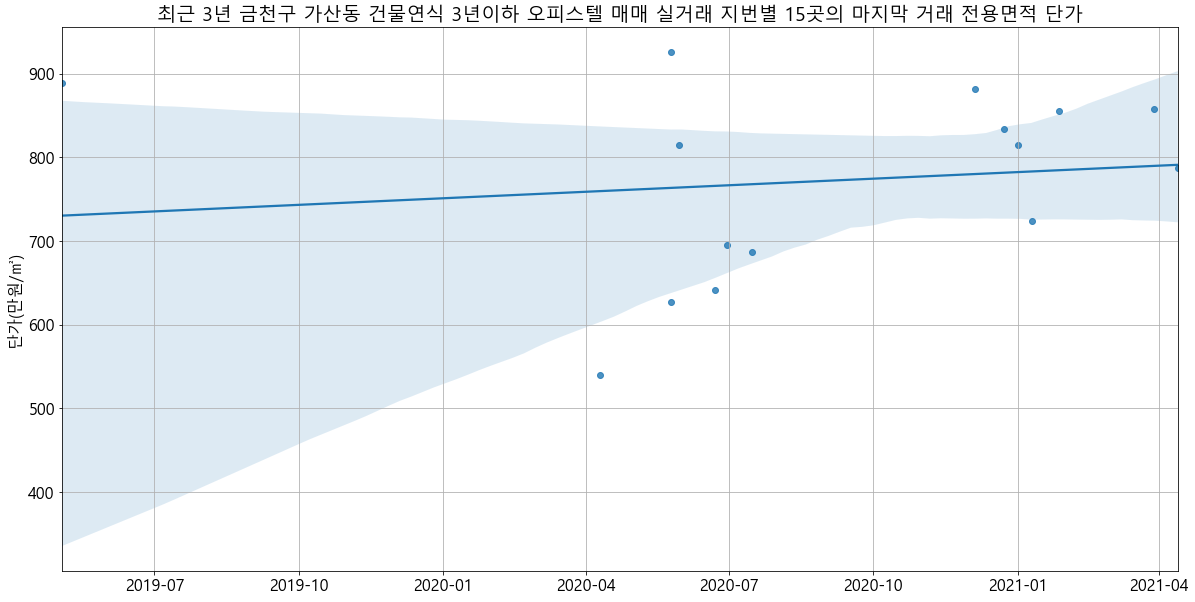

In [20]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 3년 {} {} 건물연식 3년이하 오피스텔 매매 실거래 지번별 {}곳의 마지막 거래 전용면적 단가'.format(target_gu, target_dong, concat_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(concat_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(concat_last_df['계약날짜']), y=concat_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_오피스텔/지번별_산포도.png'.format(target_gu, target_dong))

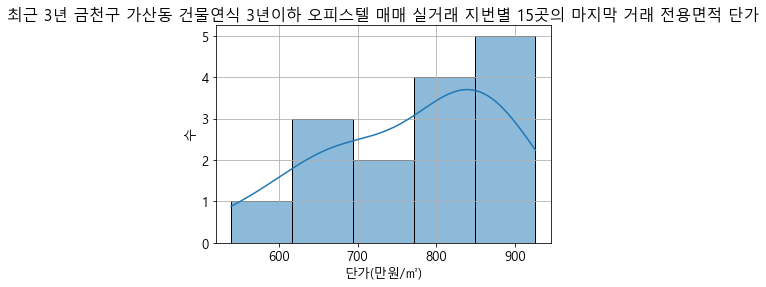

<Figure size 432x288 with 0 Axes>

In [21]:
font = {'size': 13}
matplotlib.rc('font', **font)
plt.grid(True)
plt.ylabel('수')
plt.title('최근 3년 {} {} 건물연식 3년이하 오피스텔 매매 실거래 지번별 {}곳의 마지막 거래 전용면적 단가'.format(target_gu, target_dong, concat_last_df.shape[0]))
sns.histplot(concat_last_df['단가(만원/㎡)'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_오피스텔/지번별_분포도.png'.format(target_gu, target_dong))
plt.show()
plt.clf()

In [22]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [23]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_오피스텔/실거래가.xlsx'.format(target_gu, target_dong), index=False)